# TransportSolver test

Writing new ```TransportSolver``` and ```LaxWendroff``` classes which generalize icepack's ```prognostic_solve``` to solve transport problems. This notebook tests ```TransportSolver``` out in three capacities: first, to reproduce expected thickness changes by using ```TransportSolver``` instead of ```FlowSolver```; second, to reproduce the analytic, steady-state fracture density field of Albrecht and Levermann by using ```TransportSolver``` instead of ```DamageSolver```; and third, to transport a layer of debris introduced onto the shelf from upstream.

The ice flow problem will be a 1D, unconfined ice shelf governed by the SSA. 

## Imports

In [1]:
path = '/home/sermilik/firedrake_stuff/figures/flow_flexure' #modify to preferred destination for saving figures

from abc import ABC
from firedrake import *
import icepack
from icepack.calculus import sym_grad, grad, div, FacetNormal
from icepack.models.viscosity import membrane_stress
from icepack.optimization import MinimizationProblem, NewtonSolver
from icepack.utilities import eigenvalues, default_solver_parameters
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import os
import tqdm

## Meshing, physical parameters

In [2]:
nx, ny = 100, 1 #number of elements in x, y
Lx, Ly = 10000, 5000 #length, width in meters
mesh = RectangleMesh(nx, ny, Lx, Ly)
x, y = SpatialCoordinate(mesh)

Q = FunctionSpace(mesh, 'CG', 2) 
V = VectorFunctionSpace(mesh, 'CG', 2) 
S = TensorFunctionSpace(mesh, 'DG', 1) 

u = Function(V) #velocity
v = TestFunction(V) 

H_gl = 500 #thickness at upstream boundary (m)
thick_grad = 0 #initial thickness gradient 
H0 = project(H_gl + thick_grad*x, Q) #initial thickness projected onto CG elements
ρ_i = 917 #ice density value consistent with icepack's, but in kg/m^3
ρ_w = 1024 #water density consistent with icepack, but in kg/m^3
ϱ = ρ_i/ρ_w #density ratio
g = 9.81
T = Constant(273.15) #temperature (K). 273.15 is freezing
A = icepack.rate_factor(T) #A from Glen's law
γ = 0.3 #damage rate of Albrecht and Levermann

## Write the transport solver

Couple minor changes to ```TransportEquation``` (see the "sources" function). ```TransportSolver``` and ```LaxWendroff``` are really just copied and pasted from ```icepack.solvers.flow_solver```, with thickness $h$ generalized to an arbitrary scalar field $\psi$. 

In [3]:
#####################################
#####################################
### transport equation and solver ###
#####################################
#####################################

# Copyright (C) 2023 by Daniel Shapero <shapero@uw.edu>
#
# This file is part of icepack.
#
# icepack is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# The full text of the license can be found in the file LICENSE in the
# icepack source directory or at <http://www.gnu.org/licenses/>.

###############################################
###############################################
### copy/paste icepack's transport equation ###
###############################################
###############################################

class TransportEquation(ABC):
    def __init__(self, field_name, conservative):
        self._field_name = field_name
        self._conservative = conservative

    def flux(self, **kwargs):
        keys = (self._field_name, "velocity")
        q, u = itemgetter(*keys)(kwargs)
        q_inflow = kwargs.get(f"{self._field_name}_inflow", Constant(0.0))

        if q.ufl_shape != ():
            raise NotImplementedError(
                "Transport equation only implemented for scalar problems!"
            )

        Q = q.function_space()
        φ = TestFunction(Q)

        mesh = Q.mesh()
        n = FacetNormal(mesh)
        #ds = ds if mesh.layers is None else ds_v

        if self._conservative:
            flux_cells = -inner(q * u, grad(φ)) * dx
        else:
            flux_cells = -q * div(u * φ) * dx

        flux_out = q * max_value(0, inner(u, n)) * φ * ds
        flux_in = q_inflow * min_value(0, inner(u, n)) * φ * ds

        if q.ufl_element().family() == "Discontinuous Lagrange":
            f = q * max_value(0, inner(u, n))
            flux_faces = (f("+") - f("-")) * (φ("+") - φ("-")) * dS
            return flux_cells + flux_faces + flux_out + flux_in

        return flux_cells + flux_out + flux_in

    def sources(self, **kwargs): #tweaking this to only permit (thickness, thickness_accumulation), (damage, damage_accumulation), etc.
        keys = (self._field_name, f"{self._field_name}_accumulation")
        ψ, a = itemgetter(*keys)(kwargs)
        φ = TestFunction(ψ.function_space())
        return a * φ * dx

#################################################################
#################################################################
### essentially copy/paste the relevant bits from flow_solver ###
#################################################################
#################################################################

class TransportSolver:
    def __init__(self, model, **kwargs):
        
        self._model = model
        self._fields = {}

        # Prepare the prognostic solver
        prognostic_parameters = kwargs.get(
            "prognostic_solver_parameters", default_solver_parameters
        )

        self._prognostic_solver = LaxWendroff(
            model, self._fields, prognostic_parameters
        )

    @property
    def model(self):
        r"""The physics model that this object solves"""
        return self._model

    @property
    def fields(self):
        r"""Dictionary of all fields that are part of the simulation"""
        return self._fields

    def prognostic_solve(self, dt, **kwargs):
        r"""Solve the prognostic model physics for the new value of the chosen scaler field"""
        return self._prognostic_solver.solve(dt, **kwargs)

class LaxWendroff:
    def __init__(self, model, fields, solver_parameters):
        self._model = model
        self._fields = fields
        self._solver_parameters = solver_parameters

    def setup(self, **kwargs):
        r"""Create the internal data structures that help reuse information
        from past prognostic solves"""
        for name, field in kwargs.items():
            if name in self._fields.keys():
                self._fields[name].assign(field)
            else:
                if isinstance(field, Constant):
                    self._fields[name] = Constant(field)
                elif isinstance(field, Function):
                    self._fields[name] = field.copy(deepcopy=True)
                else:
                    raise TypeError(
                        "Input %s field has type %s, must be Constant or Function!"
                        % (name, type(field))
                    )

        dt = Constant(1.0)
        ψ = self._fields[self._model._field_name] #generalized from thickness h to scalar field ψ
        u = self._fields["velocity"]
        ψ_0 = ψ.copy(deepcopy=True)

        Q = ψ.function_space()
        mesh = Q.mesh()
        n = FacetNormal(mesh)
        outflow = max_value(0, inner(u, n))
        inflow = min_value(0, inner(u, n))

        # Additional streamlining terms that give 2nd-order accuracy
        q = TestFunction(Q)
        #ds = ds if mesh.layers is None else ds_v
        flux_cells = -div(ψ * u) * inner(u, grad(q)) * dx
        flux_out = div(ψ * u) * q * outflow * ds
        flux_in = div(ψ_0 * u) * q * inflow * ds
        d2ψ_dt2 = flux_cells + flux_out + flux_in

        sources = self._model.sources(**self._fields)
        flux = self._model.flux(**self._fields)
        dψ_dt = sources - flux
        F = (ψ - ψ_0) * q * dx - dt * (dψ_dt + 0.5 * dt * d2ψ_dt2)

        problem = NonlinearVariationalProblem(F, ψ)
        self._solver = NonlinearVariationalSolver(
            problem, solver_parameters=self._solver_parameters
        )

        self._ψ_old = ψ_0
        self._timestep = dt

    def solve(self, dt, **kwargs):
        r"""Compute the evolution of the chosen scalar field after time `dt`"""
        if not hasattr(self, "_solver"):
            self.setup(**kwargs)
        else:
            for name, field in kwargs.items():
                self._fields[name].assign(field)

        ψ = self._fields[self._model._field_name]
        self._ψ_old.assign(ψ)
        self._timestep.assign(dt)
        self._solver.solve()
        return ψ.copy(deepcopy=True)

## Set up models and solvers

I'll set up the usual ```flow_solver```, but I'll only use this to solve for velocity. Mass transport and damage advection will both be solved using ```TransportEquation``` and ```TransportSolver```. 

In [4]:
#################################
#################################
### define models and solvers ###
#################################
#################################

opts = {
    'dirichlet_ids': [1], #boundaries are labeled (1, 2, 3, 4) = (upstream, downstream, left, right)
    'side_wall_ids': [3, 4],
    'ice_front_ids': [2],
    'diagnostic_solver_type': 'petsc',
    'diagnostic_solver_parameters': {
        'ksp_type': 'cg',
        'pc_type': 'mg',
        'pc_mg_cycle_type': 'w',
        'snes_line_search_type': 'cp',
    },
    'prognostic_solver_parameters': {
        'ksp_type': 'gmres',
        'pc_type': 'ilu',
    },
}

flow_model = icepack.models.IceShelf()
flow_solver = icepack.solvers.FlowSolver(flow_model, **opts)

thickness_model = TransportEquation(field_name = 'thickness', conservative = True) #instead of just using flow_model and flow_solver
thickness_solver = TransportSolver(thickness_model, **opts)

damage_model = TransportEquation(field_name = 'damage', conservative = False) #instead of icepack.models.damage_transport
damage_solver = TransportSolver(damage_model, **opts) 

# og_damage_model = icepack.models.DamageTransport(damage_stress = 0.0, healing_rate = 0.0, 
#                                                healing_strain_rate = 0.0, damage_rate = γ)
# og_damage_solver = icepack.solvers.DamageSolver(og_damage_model)

debris_model = TransportEquation(field_name = 'debris', conservative = False) #NON-conservative debris transport!
debris_solver = TransportSolver(debris_model, **opts) #value 0 will indication absence of debris; 1 means debris is present

###############################
###############################
### initial conditions, etc ###
###############################
###############################

dt = 1/2 #length of timestep in years
num_timesteps = int(50/dt) #run for 50 years

damage = Function(Q).project(Constant(0)) #no damage initially
#og_damage = damage.copy(deepcopy=True)
debris = Function(Q).project(Constant(0)) #also no debris initially
ux_gl = 100 #upstream velocity condition
u0 = project(as_vector([ux_gl, 1e-50]), V) #initial velocity for imposing Dirichlet BCs

##################################
##################################
### plot initial configuration ###
##################################
##################################

X = np.array([(k, Ly/2) for k in range (Lx+1)]) #along-flow line for getting geometry profiles
os.chdir(path) #for saving figures

s = project((1 - ϱ)*H0, Q)
b = project(-ϱ*H0, Q)

s_profile = np.array(s.at(X, tolerance = 1e-10))
b_profile = np.array(b.at(X, tolerance = 1e-10))
damage_profile = np.array(damage.at(X, tolerance = 1e-10))
#og_damage_profile = np.array(og_damage.at(X, tolerance = 1e-10))
debris_profile = np.array(debris.at(X, tolerance = 1e-10))
plt.figure()
plt.title('centerline profile, $t$ = 0.0 years')
plt.xlabel('longitudinal coordinate (m)')
plt.plot(damage_profile, color='k', linestyle = 'solid', label = 'modeled damage')
#plt.plot(og_damage_profile, color='grey', alpha = 0.5, label = 'OG modeled damage')
plt.plot(debris_profile, color='k', linestyle = 'dotted', label = 'debris cover')
plt.ylabel('fracture density, or debris presence')
plt.ylim(-0.1, 1.2)
plt.legend(loc = 'lower right')
plt.grid(linewidth=0.2)
plt.twinx()
plt.ylabel('elevation (m)')
plt.ylim(int(-ϱ*H_gl) - H_gl/10, int((1 - ϱ)*H_gl + H_gl/10))
plt.plot(s_profile, color='red', label = 'surface', linewidth=5, alpha = 0.5)
plt.plot(b_profile, color='blue', label = 'base', linewidth=5, alpha = 0.5)
plt.legend(loc = 'center right')
plt.savefig('iteration_0')
plt.close() #comment out to show initial geometry

## Iteratively solve and plot

Also saving solutions at each timestep. At each time step, we can compare modeled fracture density with the analytic, steady-state fracture density solution for an unconfined, 1D ice shelf (see Albrecht and Levermann for the analytic solution). Modeled and analytic fracture density solutions approach heach other as geometry reaches steady state. Agreement generally seems to improve with smaller timestep. 

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [05:20<00:00,  3.21s/it]


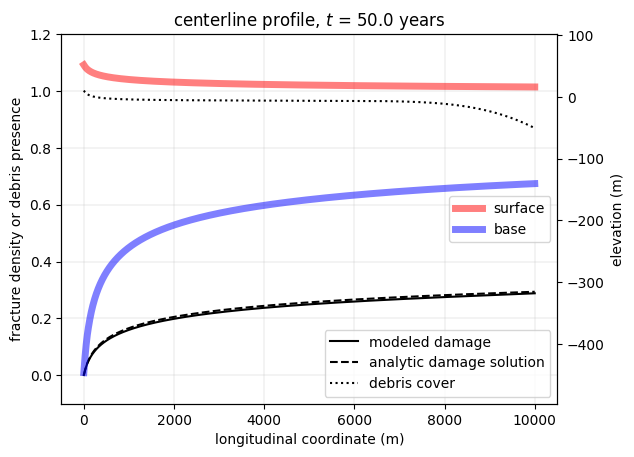

In [5]:
u, H = u0.copy(deepcopy=True), H0.copy(deepcopy=True)

for step in tqdm.trange(num_timesteps):
    
    u = flow_solver.diagnostic_solve(velocity = u, side_friction = Constant(0), thickness = H, fluidity = A)
    
    H = thickness_solver.prognostic_solve(dt, thickness = H, velocity = u,
                                thickness_inflow = Constant(H_gl), thickness_accumulation = Constant(0))
    
    ε = Function(S).project(sym_grad(u))
    #M = Function(S).project(icepack.models.viscosity.membrane_stress(strain_rate = ε, fluidity = A))
    damage_accumulation = project(0.3*eigenvalues(ε)[0]*(1 - damage), Q) #taken from DamageTransport's "sources" function
    
    damage = damage_solver.prognostic_solve(dt, damage = damage, velocity = u, damage_accumulation = damage_accumulation, 
                                       damage_inflow = Constant(0))

    # og_damage = og_damage_solver.solve(dt, damage = og_damage, velocity = u, strain_rate = ε, membrane_stress = M, 
    #                                    damage_inflow = Constant(0))

    analytic = project(1 - (u[0]/ux_gl)**-γ, Q) #analytic solution for steady-state fracture density from Albrecht & Levermann

    debris = debris_solver.prognostic_solve(dt, debris = debris, velocity = u, debris_accumulation = Constant(0), #no accumulation mechanism
                                            debris_inflow = Constant(1)) #debris flows into the domain from the left
    
    s = project((1 - ϱ)*H, Q) #surface elevation
    b = project(-ϱ*H, Q) #basal elevation

    ####################
    ####################
    ### plot results ###
    ####################
    ####################

    s_profile = np.array(s.at(X, tolerance = 1e-10))
    b_profile = np.array(b.at(X, tolerance = 1e-10))
    damage_profile = np.array(damage.at(X, tolerance = 1e-10))
    #og_damage_profile = np.array(og_damage.at(X, tolerance = 1e-10))
    debris_profile = np.array(debris.at(X, tolerance = 1e-10))
    analytic_profile = np.array(analytic.at(X, tolerance = 1e-10))
    plt.figure()
    plt.title('centerline profile, $t$ = {:.1f} years'.format(step*dt + dt))
    plt.xlabel('longitudinal coordinate (m)')
    plt.plot(damage_profile, color='k', linestyle = 'solid', label = 'modeled damage')
    #plt.plot(og_damage_profile, color='grey', linestyle = 'solid', label = 'OG modeled damage', alpha = 0.5)
    plt.plot(analytic_profile, color='k', linestyle = 'dashed', label = 'analytic damage solution')
    plt.plot(debris_profile, color='k', linestyle = 'dotted', label = 'debris cover')
    plt.legend(loc = 'lower right')
    plt.ylabel('fracture density or debris presence')
    plt.ylim(-0.1, 1.2)
    plt.grid(linewidth=0.2)
    plt.twinx()
    plt.ylabel('elevation (m)')
    plt.ylim(int(-ϱ*H_gl) - H_gl/10, int((1 - ϱ)*H_gl + H_gl/10))
    plt.plot(s_profile, color='red', label = 'surface', linewidth=5, alpha = 0.5)
    plt.plot(b_profile, color='blue', label = 'base', linewidth=5, alpha = 0.5)
    plt.legend(loc = 'center right')
    plt.savefig('iteration_{}'.format(step + 1))
    if step < num_timesteps - 1:
        plt.close() #save all plots but only show the last iteration